# Learning Goal: demonstrating "long-term" selection

The mutation rate possessed by a single organism does not affect its fitness. That is, there is selection *on the organism's external phenotype*, but because mutation rate only *in the offspring*, is not "visible"" to single-generation selection. 

Nonetheless, this lab will demonstrate that there is “long-term selection” on mutation rate because it produces differential survival of clades.

# Setup
### Six possible genotypes

We will consider a fixed population size of N=10<sup>9</sup> individual organisms, each of which has a certain genotype.

There are two possible alleles at the "major locus”: *A* and *B*. The “major locus” means the locus under selection. The alleles *A* and *B* will have different fitnesses.

There are three possible alleles at the "mutator locus": *M<sub>2</sub>*, *M<sub>3</sub>*, *M<sub>4</sub>*. There is no direct selection on the mutator locus; it jsut sets the rate of mutation from *A*->*B* or *B*->*A* in offspring.

This makes a total of 2 * 3 = 6 possible genotypes:

|                   | A                       | B |
| :---------------- | :------:                | :----: |
| *M<sub>2</sub>*   |   (*M<sub>2</sub>*, A)  | (*M<sub>2</sub>*, B) |
| *M<sub>3</sub>*   |   (*M<sub>3</sub>*, A)  | (*M<sub>3</sub>*, B) |
| *M<sub>4</sub>*   |   (*M<sub>4</sub>*, A)  | (*M<sub>4</sub>*, B) |


### Each generation of evolution
At each generation, in a typical population genetics model (like this one), we will:

1. Apply **selection** to determine the *number of offspring* that each individual organism will have.
2. Apply **mutation** to the major allele at a certain mutation rate.

If there's no mutation, the offspring inherits the parent's value of A or B. If there is a mutation, the inherited allele switches *A->B* or *B->A* from the parent's value.

### Selection
There will be two environments in our model. At any generation the current "environmental state” is either *A* or *B*. This state will fluctuate over time on a schedule that I will explain below.

Environment *A* favors major allele *A*, and environment *B* favors major allele *B*.

Organisms holding the allele at the major locus that matches the state of the environment will produce more offspring than organisms with the other allele: they are more fit.

Specifically, given a “selection coefficient” *s*, the matching (fitter) organisms produce 1+*s* times more offspring than the less fit organisms. This means that the fitter organisms will increase in relative number. (We fix *s* = 0.1)

### Mutation
The alleles M2, M3, M4 at the mutator locus produce mutation rates in the major locus of 10-2, 10-3, 10-4, respectively. The rate is symmetric, A->B, or B->A.

For example, at each generation, an individual with genotype (A, M2) produces offspring that are 99% (A, M2), and 1% (B, M2); that is, the A mutates to B in 1 out of 102 offspring.

Similarly, an individual with genotype (A, M4) produces offspring that are 99.99% (A, M4), and 0.01% (B, M4);  that is, the A mutates to B in 1 out of 104 offspring.

In the other direction, for example, an individual with genotype (B, M2) produces offspring that are 99% (B, M2), and 1% (A, M2); that is, the a mutates to A in 1 out of 102 offspring.

The mutator locus itself never mutates. That means that all descendants of an individual possessing an M2 at the mutator locus will always possess an M2 (and likewise for M3, M4). This constraint in our particular experimental setup makes the mutator locus a convenient marker of clade identity. So, we can refer to the M2 clade as being founded by all the M2 individuals at generation 0, and all of its descendant members will always possess an M2 forever.


# Learning Goal (elaborated):

In each generation,
- Selection determines the *number of offspring* an organism has – its fitness.
- However, selection does not determine the *genotypes of the offspring*.
- Rather, *the mutation rate* determines the *distribution of genotypes* in the offspring.

So, individual organisms are selected (i.e., their fitness is determined) depending *only* on the allele they hold at the major locus, and whether it matches the environmental state.

The mutation rate is not "visible" to selection over one generation.

However – by affecting the distribution of genotypes in the offspring – the mutation rate becomes visible to multi-generation selection.

Recall that a clade will "survive" (or not) if it retains one member (or not). That depends on the distribution of the offspring genotypes.

That is, clades can experience "long-term" selection on mutation rate, and mutation rate is visible to long-term selection!

- Moreover, this is just a special case of a more general selection on clades for not just mutation rate, but *for anything that affects the distribution of genotypes in their members*.

- More-moreover, in the even longer-term, there is selection on *change* in mutation rate... and the change in *that*... and the change in *that*! That is, there is a recursive dynamic! (but not in this demonstration because we fix the mutation rates)


# Simulations

In [357]:
from importlib import reload
from helpers import *
import evosim
reload(evosim)
print(evosim.default_args)

{'numPops': 1, 'N': 1000000000.0, 'minMu': 2, 'numClades': 1, 'aToB': 0.5, 'numEpochs': 1, 'T': 1000.0, 's': 0.1, 'skipMutation': False, 'plotLog': False, 'plotAB': True, 'print_each_epoch': True}


### Drift (without selection or mutation)

Drift is stronger with low N (population size).

- Change N between 1e2 and 1e9

Re-run (Ctrl-return) multiple times with different parameters.

=== === === === === === === === Starting evosim
args: {'numPops': 1, 'N': 100000000.0, 'minMu': 2, 'numClades': 3, 'aToB': 0.5, 'numEpochs': 3, 'T': 1000.0, 's': 0.01, 'skipMutation': True, 'plotLog': False, 'plotAB': True, 'print_each_epoch': True}
Ns:1000000.0 >= 10.0 (selection is STRONG relative to drift)
sT:10.0 is low < 20.0 (fixation WON'T usually happen in one epoch)
gen:0 epoch:0
	pop 0	env: A	sA=0.01	sB=0.0	sumN: 99998431.00
		clade M2:	mu:1.0e-02)	(n=33331027	 nA=16667100	 nB=16663927)
		clade M3:	mu:1.0e-03)	(n=33333922	 nA=16671682	 nB=16662240)
		clade M4:	mu:1.0e-04)	(n=33333482	 nA=16664524	 nB=16668958)
gen:1000 epoch:1
	pop 0	env: B	sA=0.0	sB=0.01	sumN: 99993739.00
		clade M2:	mu:1.0e-02)	(n=33266676	 nA=33265458	 nB=  1218)
		clade M3:	mu:1.0e-03)	(n=33258124	 nA=33256770	 nB=  1354)
		clade M4:	mu:1.0e-04)	(n=33468939	 nA=33467309	 nB=  1630)
gen:2000 epoch:2
	pop 0	env: A	sA=0.01	sB=0.0	sumN: 99999762.00
		clade M2:	mu:1.0e-02)	(n=31554215	 nA=16836362	 nB=14717853

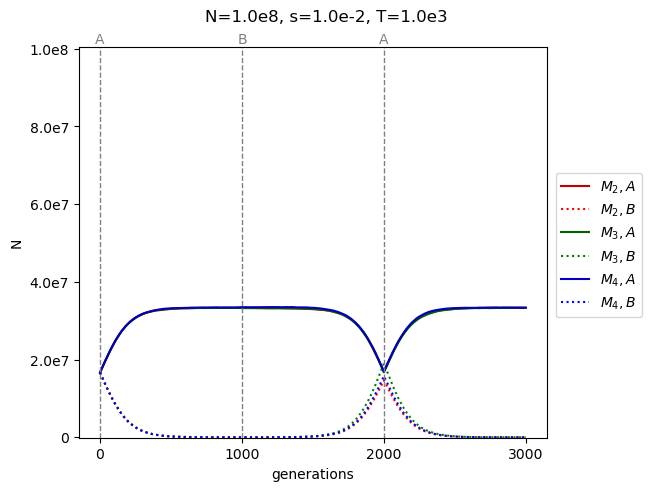

=== === === === === === === === Elapsed time for evosim: 0.26 seconds


In [365]:
# goal: to see effect of population size on drift

override_args = evosim.DotAccessibleDict()

override_args.s = 0.01 # no selection
override_args.skipMutation = True # no mutation
override_args.print_each_epoch = True

override_args.numClades = 3
override_args.numEpochs = 3
override_args.N = 1e8 # change N between 1e2 and 1e9, re-run multple times (Ctrl-return) 

evosim.evosim(override_args)

### Selection (without mutation)

Change N to see differential effect of selection vs drift.

Change s to see effect of selection strength.

- if sT is low (<= 5.0), then fixation won't usually happen in one epoch (T generations)
- if Ns is low (<= 1.0), then drift will be strong relative to selection
- Type *A* should fix if Ns > 1, and sT > 5


Re-run multiple times (Ctrl-return) with different parameters.

=== === === === === === === === Starting evosim
args: {'numPops': 1, 'N': 1000.0, 'minMu': 2, 'numClades': 1, 'aToB': 0.5, 'numEpochs': 1, 'T': 1000.0, 's': 0.005, 'skipMutation': True, 'plotLog': False, 'plotAB': True, 'print_each_epoch': True}
Ns:5.0 is low < 10.0 (selection is WEAK relative to drift)
sT:5.0 is low < 20.0 (fixation WON'T usually happen in one epoch)
gen:0 epoch:0
	pop 0	env: A	sA=0.005	sB=0.0	sumN: 1004.00
		clade M2:	mu:1.0e-02)	(n=  1004	 nA=   496	 nB=   508)


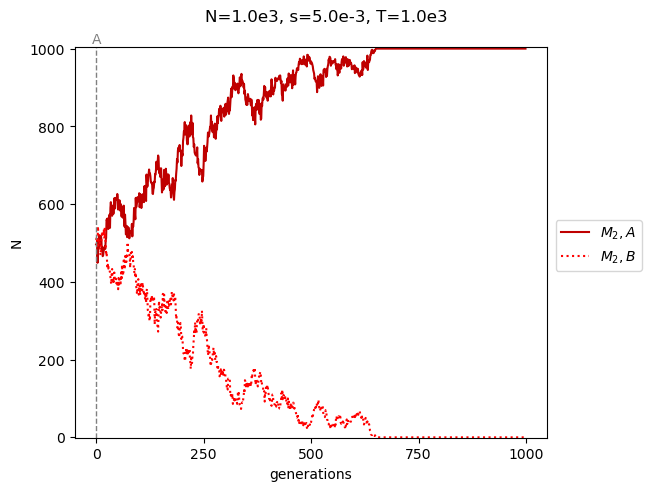

=== === === === === === === === Elapsed time for evosim: 0.06 seconds


In [359]:
override_args = evosim.DotAccessibleDict()

override_args.s = 0.005
override_args.skipMutation = True # no mutation
override_args.N = 1e3

evosim.evosim(override_args)

### Selection and mutation

=== === === === === === === === Starting evosim
args: {'numPops': 1, 'N': 10000.0, 'minMu': 2, 'numClades': 2, 'aToB': 0.5, 'numEpochs': 1, 'T': 1000.0, 's': 0.01, 'skipMutation': False, 'plotLog': False, 'plotAB': True, 'print_each_epoch': True}
Ns:100.0 >= 10.0 (selection is STRONG relative to drift)
sT:10.0 is low < 20.0 (fixation WON'T usually happen in one epoch)
gen:0 epoch:0
	pop 0	env: A	sA=0.01	sB=0.0	sumN: 10014.00
		clade M2:	mu:1.0e-02)	(n=  4966	 nA=  2487	 nB=  2479)
		clade M3:	mu:1.0e-03)	(n=  5048	 nA=  2527	 nB=  2521)


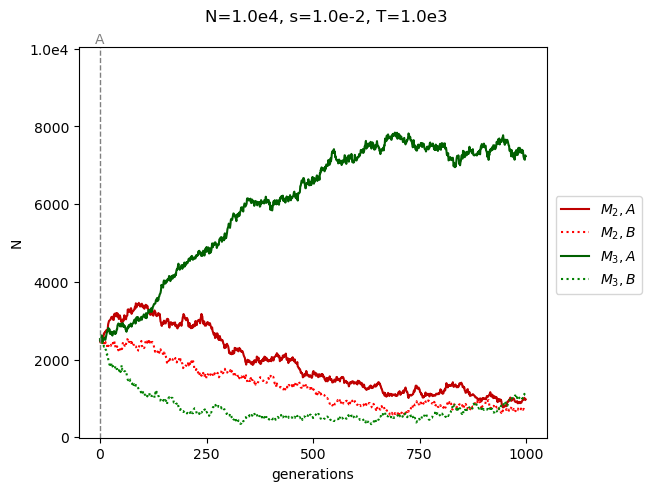

=== === === === === === === === Elapsed time for evosim: 0.10 seconds


In [360]:
override_args = evosim.DotAccessibleDict()

override_args.numClades = 2

override_args.s = 0.01 # change this to see effect of selection strength
override_args.N = 1e4 # change this and re-run to see differential effect of selection vs drift

evosim.evosim(override_args)

### Selection in alternating environments

=== === === === === === === === Starting evosim
args: {'numPops': 1, 'N': -1, 'minMu': 2, 'numClades': 1, 'aToB': 0.5, 'numEpochs': 4, 'T': 1000.0, 's': 0.1, 'skipMutation': False, 'plotLog': False, 'plotAB': True, 'print_each_epoch': False}
Infinite population size N (there is no drift)
sT:100.0 >= 20.0 (fixation CAN happen in one epoch (ignoring mutation))


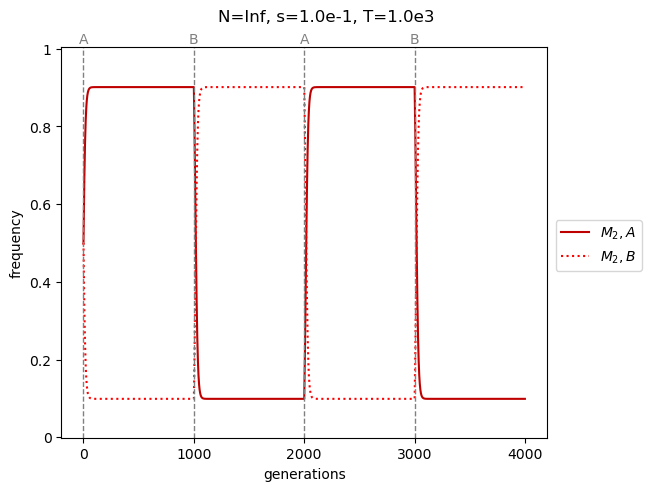

=== === === === === === === === Elapsed time for evosim: 0.04 seconds


In [361]:
override_args = evosim.DotAccessibleDict()

override_args.minMu = 2
override_args.numClades = 1

override_args.s = 0.1 # change this to see effect of selection strength
override_args.skipMutation = False

override_args.T = 1e3
override_args.numEpochs = 4
override_args.print_each_epoch = False

override_args.N = -1 # change this and re-run to see differential effect of selection vs drift
override_args.plotAB = True

evosim.evosim(override_args)

### Selection on different mutators (!!) in alternating environments

=== === === === === === === === Starting evosim
args: {'numPops': 1, 'N': 100000.0, 'minMu': 2, 'numClades': 3, 'aToB': 0.5, 'numEpochs': 4, 'T': 1000.0, 's': 0.1, 'skipMutation': False, 'plotLog': False, 'plotAB': True, 'print_each_epoch': False}
Ns:10000.0 >= 10.0 (selection is STRONG relative to drift)
sT:100.0 >= 20.0 (fixation CAN happen in one epoch (ignoring mutation))


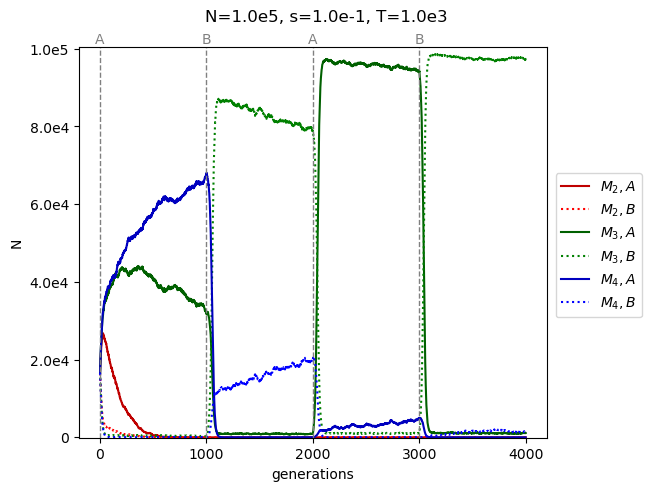

=== === === === === === === === Elapsed time for evosim: 0.26 seconds


In [362]:
override_args = evosim.DotAccessibleDict()

override_args.minMu = 2
override_args.numClades = 3

override_args.s = 0.1 # change this to see effect of selection strength
override_args.skipMutation = False

override_args.T = 1e3
override_args.numEpochs = 4
override_args.print_each_epoch = False

override_args.N = 1e5 # change this and re-run to see differential effect of selection vs drift
override_args.plotAB = True

evosim.evosim(override_args)